Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


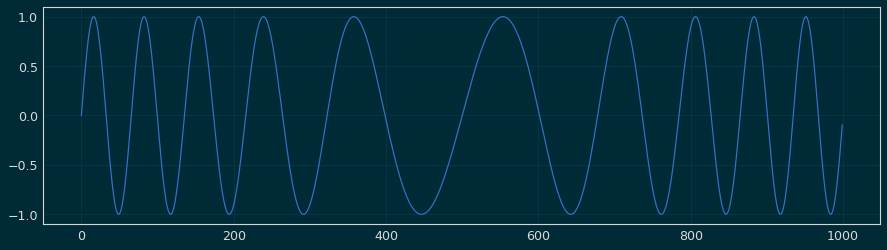

M=10000
Signal Length M=10000


In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 


print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:2'
torch.set_num_threads(4)

fs = 100000 # sampling frequency, Hz
fc = 1000  # carrier frequency, Hz
fm = 100   # modulation frequency, Hz
T = 1. # seconds
twopi = 2*np.pi
t = np.linspace(0, T, int(T*fs), endpoint=False) # time variable
# Produce ramp from 0 to 1
beta = np.linspace(0, 6., int(T*fs)) # increase by two's for slower
signal = np.sin(twopi*fc*t + beta*np.sin(twopi*fm*t))[-10000:]
FREERUN  = 0
plt.figure(figsize=(15,4))
plt.plot(signal[:1000])
plt.show()

M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 500
REG = 1e-8
TRAINLENGTH = M-TEST
print(f'M={M}')
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
print(f'Signal Length M={M}')

In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
min_a, max_a = .2, .3
min_sr, max_sr = .35, .55
min_g, max_g = .2, 1.8
min_ri, max_ri = .001, 5.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .3)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        #ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./S4_Saved_Models/S4_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./S4_Saved_Models/S4_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./S4_Saved_Models/S4_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./S4_Saved_Models/S4_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)  
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss


 ********** size300 ref0 run 0 ***********
Iter: 0 #### Diagnostic 1000.000   Time 7.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 0.471   Time 3.30  Best 1000.000 NRMSE 0.471 CD 0.907
Iter: 2 #### Diagnostic 0.474   Time 3.50  Best 1000.000 NRMSE 0.474 CD 0.905


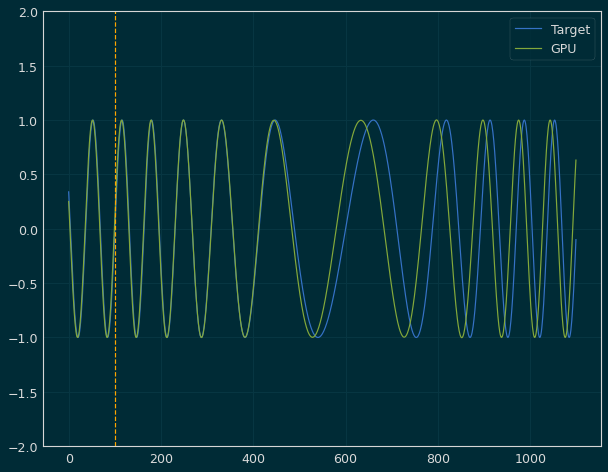

 Iter=3 a=0.267 sr=0.544 amp=1.782  ri=3.891 rr=0.127 loss=0.250184


Iter: 3 #### Diagnostic 0.250   Time 3.68  Best 0.250 NRMSE 0.250 CD 0.251
Iter: 4 #### Diagnostic 1000.000   Time 3.31  Best 0.250 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 3.10  Best 0.250 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 3.40  Best 0.250 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 3.37  Best 0.250 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 3.19  Best 0.250 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 3.17  Best 0.250 NRMSE 1201937053.237 CD 0.990
Iter: 10 #### Diagnostic 1000.000   Time 3.15  Best 0.250 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 3.18  Best 0.250 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 3.13  Best 0.250 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 3.10  Best 0.250 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 3.26  Best 0

Iter: 3 #### Diagnostic 1000.000   Time 3.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.505   Time 3.13  Best 1000.000 NRMSE 0.505 CD 1.019
Iter: 5 #### Diagnostic 0.541   Time 3.22  Best 1000.000 NRMSE 0.541 CD 1.170
Iter: 6 #### Diagnostic 1000.000   Time 3.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 3.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 3.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.491   Time 3.16  Best 1000.000 NRMSE 0.491 CD 0.960
Iter: 10 #### Diagnostic 0.530   Time 3.19  Best 1000.000 NRMSE 0.530 CD 1.120
Iter: 11 #### Diagnostic 1000.000   Time 3.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.540   Time 3.25  Best 1000.000 NRMSE 0.540 CD 0.972
Iter: 13 #### Diagnostic 1000.000   Time 3.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 3.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.495 

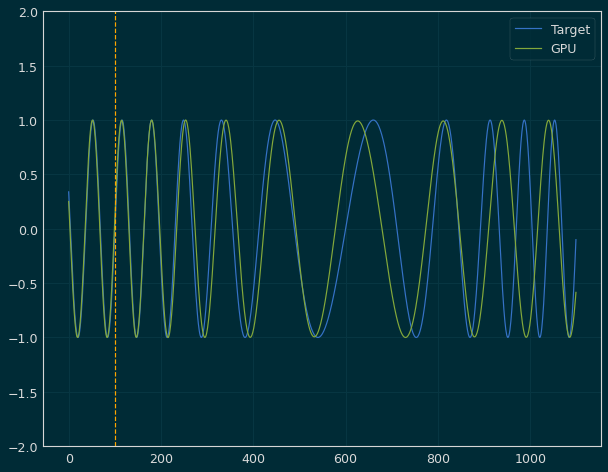

 Iter=24 a=0.230 sr=0.543 amp=1.140  ri=4.145 rr=3.162 loss=0.292715


Iter: 24 #### Diagnostic 0.293   Time 3.60  Best 0.293 NRMSE 0.293 CD 0.343
Iter: 25 #### Diagnostic 1000.000   Time 3.08  Best 0.293 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 3.18  Best 0.293 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 3.30  Best 0.293 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 3.24  Best 0.293 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 3.26  Best 0.293 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 3.52  Best 0.293 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 3.31  Best 0.293 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 3.17  Best 0.293 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 3.20  Best 0.293 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 3.18  Best 0.293 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 3.15  Best 0

Iter: 23 #### Diagnostic 1000.000   Time 3.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 3.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.541   Time 3.27  Best 1000.000 NRMSE 0.541 CD 1.168
Iter: 26 #### Diagnostic 1000.000   Time 3.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 3.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 3.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 3.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 3.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 3.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 3.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.371   Time 3.29  Best 1000.000 NRMSE 0.371 CD 0.552
Iter: 34 #### Diagnostic 1000.000   Time 3.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 ###

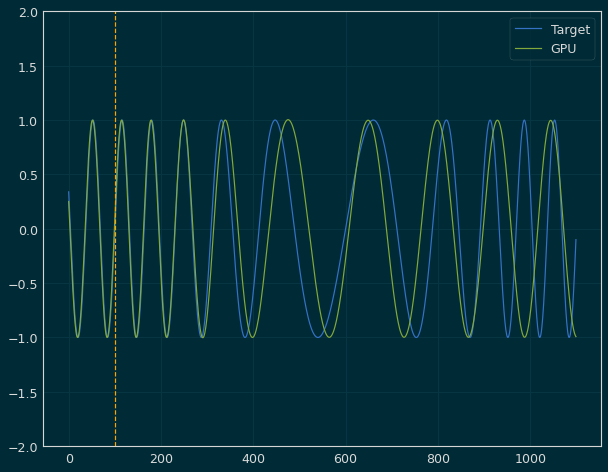

 Iter=60 a=0.260 sr=0.547 amp=1.187  ri=2.856 rr=3.550 loss=0.298995


Iter: 60 #### Diagnostic 0.299   Time 3.60  Best 0.299 NRMSE 0.299 CD 0.358
Iter: 61 #### Diagnostic 1000.000   Time 3.15  Best 0.299 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 3.29  Best 0.299 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 3.17  Best 0.299 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 3.26  Best 0.299 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 3.07  Best 0.299 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 3.61  Best 0.299 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 3.72  Best 0.299 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.445   Time 3.28  Best 0.299 NRMSE 0.445 CD 0.790
Iter: 69 #### Diagnostic 1000.000   Time 3.27  Best 0.299 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 3.29  Best 0.299 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 3.20  Best 0.299

Iter: 58 #### Diagnostic 1000.000   Time 3.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 3.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 3.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 3.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 3.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 3.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 3.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 3.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 0.450   Time 3.16  Best 1000.000 NRMSE 0.450 CD 0.816
Iter: 67 #### Diagnostic 0.511   Time 3.16  Best 1000.000 NRMSE 0.511 CD 0.954
Iter: 68 #### Diagnostic 1000.000   Time 3.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 3.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 ###

Iter: 56 #### Diagnostic 1000.000   Time 3.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 3.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 3.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 3.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 3.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 3.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 3.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 3.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 3.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 0.409   Time 3.09  Best 1000.000 NRMSE 0.409 CD 0.669
Iter: 66 #### Diagnostic 1000.000   Time 3.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 0.378   Time 3.62  Best 1000.000 NRMSE 0.378 CD 0.570
Iter: 68 ###

Iter: 47 #### Diagnostic 1000.000   Time 3.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 3.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 3.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 0.536   Time 3.18  Best 1000.000 NRMSE 0.536 CD 1.148
Iter: 51 #### Diagnostic 1000.000   Time 3.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 0.464   Time 3.22  Best 1000.000 NRMSE 0.464 CD 0.867
Iter: 53 #### Diagnostic 0.422   Time 3.31  Best 1000.000 NRMSE 0.422 CD 0.712
Iter: 54 #### Diagnostic 1000.000   Time 3.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 3.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 3.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 3.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 3.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Di

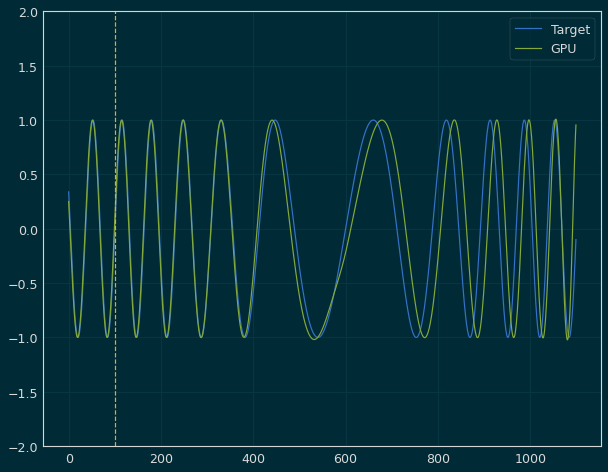

 Iter=85 a=0.203 sr=0.394 amp=1.635  ri=4.040 rr=0.954 loss=0.204012


Iter: 85 #### Diagnostic 0.204   Time 3.55  Best 0.204 NRMSE 0.204 CD 0.167
Iter: 86 #### Diagnostic 1000.000   Time 3.20  Best 0.204 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 3.26  Best 0.204 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 3.06  Best 0.204 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 3.24  Best 0.204 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 3.30  Best 0.204 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 3.22  Best 0.204 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 3.62  Best 0.204 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 3.34  Best 0.204 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 0.415   Time 3.33  Best 0.204 NRMSE 0.415 CD 0.947
Iter: 95 #### Diagnostic 1000.000   Time 3.29  Best 0.204 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000   Time 3.22  Best 0.204

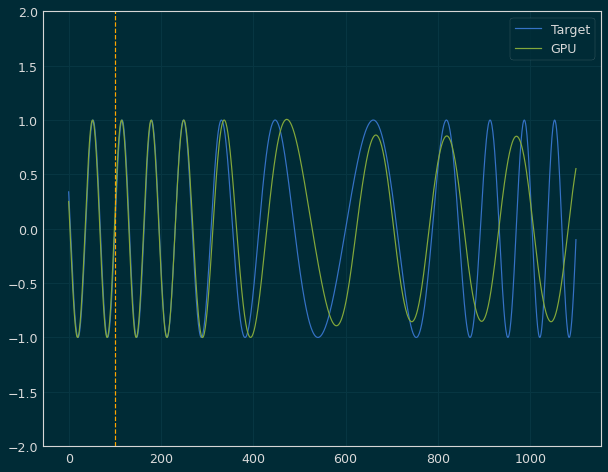

 Iter=55 a=0.245 sr=0.533 amp=1.609  ri=3.360 rr=0.397 loss=0.298781


Iter: 55 #### Diagnostic 0.299   Time 3.64  Best 0.299 NRMSE 0.299 CD 0.384
Iter: 56 #### Diagnostic 1000.000   Time 3.36  Best 0.299 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 3.23  Best 0.299 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 3.40  Best 0.299 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 3.19  Best 0.299 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 3.26  Best 0.299 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 3.25  Best 0.299 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 3.18  Best 0.299 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 3.15  Best 0.299 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 0.439   Time 3.27  Best 0.299 NRMSE 0.439 CD 0.773
Iter: 65 #### Diagnostic 1000.000   Time 3.41  Best 0.299 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 3.61  Best 0.299

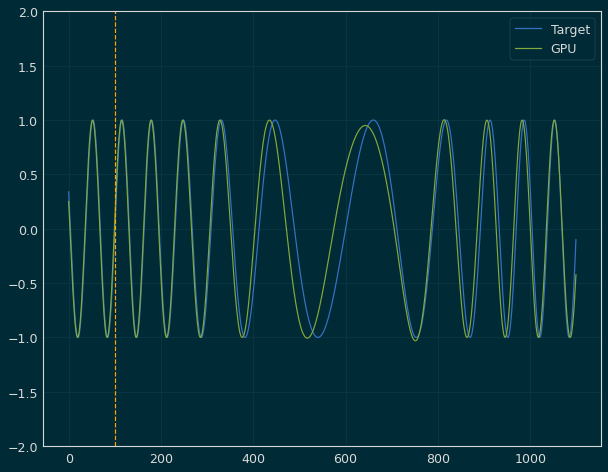

 Iter=52 a=0.211 sr=0.493 amp=1.528  ri=3.174 rr=1.702 loss=0.135940


Iter: 52 #### Diagnostic 0.136   Time 3.42  Best 0.136 NRMSE 0.136 CD 0.074
Iter: 53 #### Diagnostic 1000.000   Time 3.15  Best 0.136 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 3.04  Best 0.136 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 3.18  Best 0.136 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 3.14  Best 0.136 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 3.25  Best 0.136 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 3.22  Best 0.136 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 3.25  Best 0.136 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.521   Time 3.10  Best 0.136 NRMSE 0.521 CD 1.088
Iter: 61 #### Diagnostic 1000.000   Time 3.20  Best 0.136 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 3.35  Best 0.136 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 3.06  Best 0.136

Iter: 50 #### Diagnostic 1000.000   Time 3.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 3.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 3.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 3.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 2.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 3.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 3.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 3.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 3.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 3.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 48 #### Diagnostic 0.427   Time 3.07  Best 1000.000 NRMSE 0.427 CD 0.734
Iter: 49 #### Diagnostic 0.439   Time 2.92  Best 1000.000 NRMSE 0.439 CD 0.686
Iter: 50 #### Diagnostic 1000.000   Time 3.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 3.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 3.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 2.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 2.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.439   Time 3.05  Best 1000.000 NRMSE 0.439 CD 0.768
Iter: 57 #### Diagnostic 1000.000   Time 2.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 3.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 3.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Di

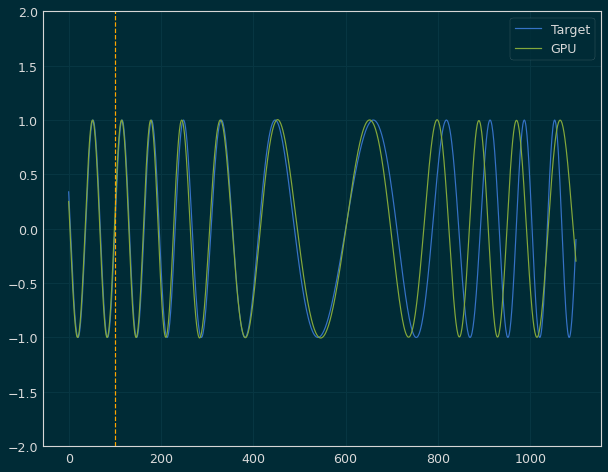

 Iter=38 a=0.261 sr=0.385 amp=1.673  ri=1.706 rr=1.015 loss=0.270269


Iter: 38 #### Diagnostic 0.270   Time 3.67  Best 0.270 NRMSE 0.270 CD 0.293
Iter: 39 #### Diagnostic 1000.000   Time 3.15  Best 0.270 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 3.11  Best 0.270 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.91  Best 0.270 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.85  Best 0.270 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.97  Best 0.270 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 3.03  Best 0.270 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.99  Best 0.270 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 3.01  Best 0.270 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.93  Best 0.270 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.93  Best 0.270 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 3.21  Best 0

Iter: 37 #### Diagnostic 1000.000   Time 2.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 0.468   Time 2.95  Best 1000.000 NRMSE 0.468 CD 0.871
Iter: 41 #### Diagnostic 1000.000   Time 3.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 3.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 0.426   Time 2.95  Best 1000.000 NRMSE 0.426 CD 0.727
Iter: 44 #### Diagnostic 1000.000   Time 3.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 3.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 3.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 3.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 ###

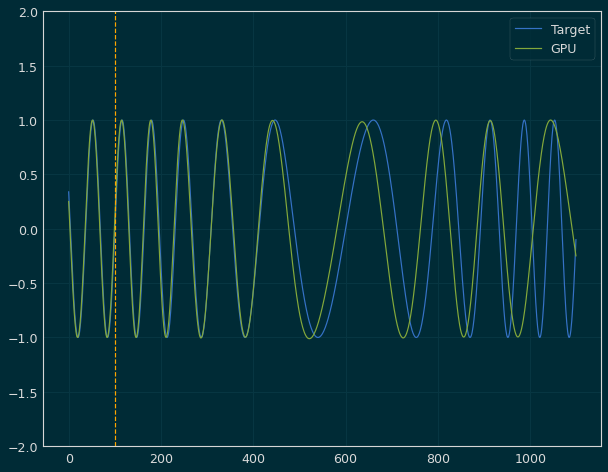

 Iter=71 a=0.217 sr=0.408 amp=1.272  ri=2.487 rr=0.323 loss=0.278622


Iter: 71 #### Diagnostic 0.279   Time 3.42  Best 0.279 NRMSE 0.279 CD 0.313
Iter: 72 #### Diagnostic 1000.000   Time 3.03  Best 0.279 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.94  Best 0.279 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 0.511   Time 2.97  Best 0.279 NRMSE 0.511 CD 1.047
Iter: 75 #### Diagnostic 1000.000   Time 2.89  Best 0.279 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 2.84  Best 0.279 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 2.84  Best 0.279 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 2.92  Best 0.279 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.96  Best 0.279 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.95  Best 0.279 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.473   Time 3.00  Best 0.279 NRMSE 0.473 CD 0.897
Iter: 82 #### Diagnostic 1000.000   Time 3.06  Best 0.279 NRM

Iter: 69 #### Diagnostic 0.443   Time 3.01  Best 1000.000 NRMSE 0.443 CD 0.788
Iter: 70 #### Diagnostic 1000.000   Time 2.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 3.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 3.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 3.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 3.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 3.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 3.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 3.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81

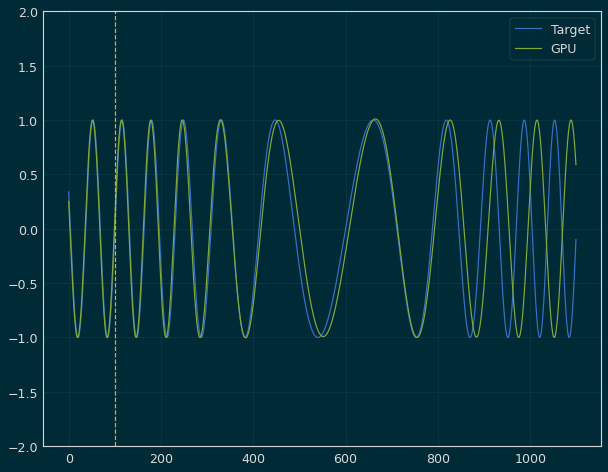

 Iter=30 a=0.234 sr=0.471 amp=1.588  ri=4.637 rr=3.540 loss=0.296634


Iter: 30 #### Diagnostic 0.297   Time 3.25  Best 0.297 NRMSE 0.297 CD 0.351
Iter: 31 #### Diagnostic 1000.000   Time 3.00  Best 0.297 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 3.06  Best 0.297 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 3.00  Best 0.297 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 3.04  Best 0.297 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 3.06  Best 0.297 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 3.03  Best 0.297 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 3.12  Best 0.297 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 3.11  Best 0.297 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 3.12  Best 0.297 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 3.01  Best 0.297 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.92  Best 0

Iter: 29 #### Diagnostic 1000.000   Time 2.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 3.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 3.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 2.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 3.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 2.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 3.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 3.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 3.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 0.535   Time 3.18  Best 1000.000 NRMSE 0.535 CD 1.147
Iter: 41

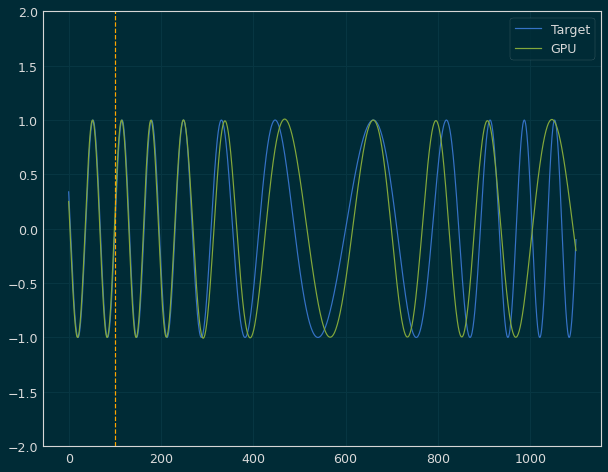

 Iter=78 a=0.243 sr=0.548 amp=1.384  ri=1.215 rr=1.637 loss=0.284805


Iter: 78 #### Diagnostic 0.285   Time 3.67  Best 0.285 NRMSE 0.285 CD 0.326
Iter: 79 #### Diagnostic 1000.000   Time 3.03  Best 0.285 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 3.00  Best 0.285 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.93  Best 0.285 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 3.21  Best 0.285 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.94  Best 0.285 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 3.08  Best 0.285 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.97  Best 0.285 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.97  Best 0.285 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 0.485   Time 2.99  Best 0.285 NRMSE 0.485 CD 0.933
Iter: 88 #### Diagnostic 1000.000   Time 2.93  Best 0.285 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 0.480   Time 2.91  Best 0.285 NR

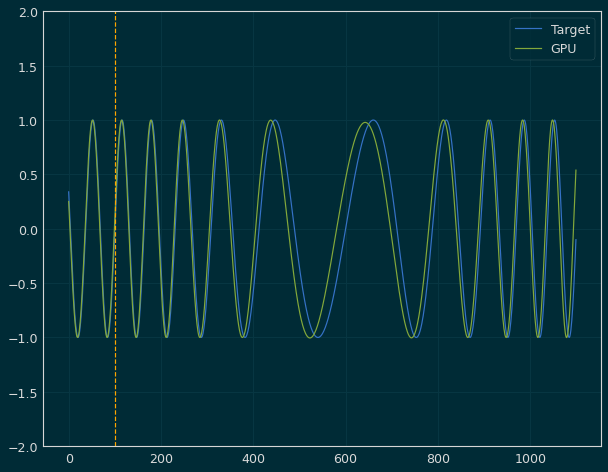

 Iter=20 a=0.226 sr=0.495 amp=1.661  ri=4.384 rr=4.039 loss=0.133145


Iter: 20 #### Diagnostic 0.133   Time 3.36  Best 0.133 NRMSE 0.133 CD 0.071
Iter: 21 #### Diagnostic 1000.000   Time 3.06  Best 0.133 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 3.02  Best 0.133 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 2.99  Best 0.133 NRMSE 7086272342711065600.000 CD 1.000
Iter: 24 #### Diagnostic 1000.000   Time 3.49  Best 0.133 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 3.06  Best 0.133 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 3.09  Best 0.133 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 3.02  Best 0.133 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 3.02  Best 0.133 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 3.07  Best 0.133 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 3.05  Best 0.133 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   

Iter: 20 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.442   Time 2.57  Best 1000.000 NRMSE 0.442 CD 0.785
Iter: 25 #### Diagnostic 0.491   Time 2.58  Best 1000.000 NRMSE 0.491 CD 0.958
Iter: 26 #### Diagnostic 0.490   Time 2.57  Best 1000.000 NRMSE 0.490 CD 0.952
Iter: 27 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.439   Time 2.57  Best 1000.000 NRMSE 0.439 CD 0.775
Iter: 31 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagno

Iter: 17 #### Diagnostic 1000.000   Time 2.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.454   Time 2.57  Best 1000.000 NRMSE 0.454 CD 0.825
Iter: 19 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 5.326   Time 2.57  Best 1000.000 NRMSE 5.326 CD 0.995
Iter: 21 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.380   Time 2.58  Best 1000.000 NRMSE 0.380 CD 0.575
Iter: 25 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Di

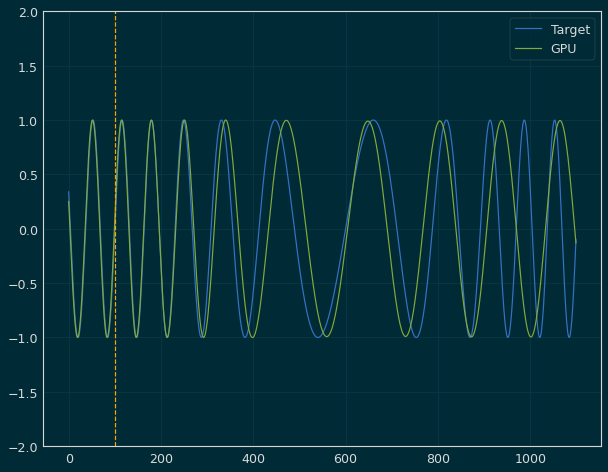

 Iter=36 a=0.244 sr=0.521 amp=1.751  ri=3.601 rr=2.051 loss=0.297251


Iter: 36 #### Diagnostic 0.297   Time 2.92  Best 0.297 NRMSE 0.297 CD 0.356
Iter: 37 #### Diagnostic 1000.000   Time 2.59  Best 0.297 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.57  Best 0.297 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.59  Best 0.297 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.59  Best 0.297 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.60  Best 0.297 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.59  Best 0

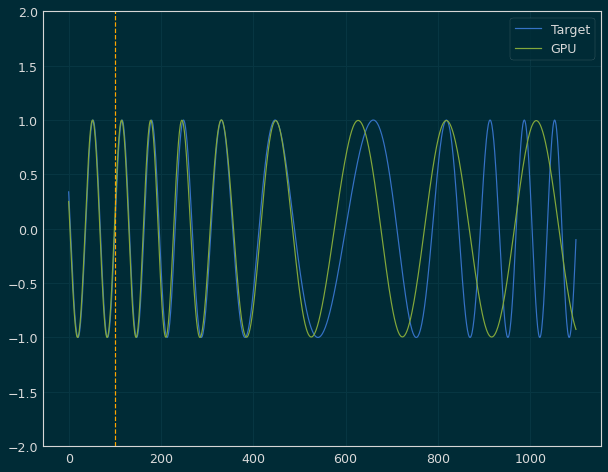

 Iter=81 a=0.296 sr=0.460 amp=1.341  ri=3.803 rr=1.584 loss=0.295538


Iter: 81 #### Diagnostic 0.296   Time 3.13  Best 0.296 NRMSE 0.296 CD 0.353
Iter: 82 #### Diagnostic 1000.000   Time 2.58  Best 0.296 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.57  Best 0.296 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.59  Best 0.296 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.57  Best 0.296 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.57  Best 0.296 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 0.479   Time 2.57  Best 0.296 NRMSE 0.479 CD 0.919
Iter: 88 #### Diagnostic 1000.000   Time 2.58  Best 0.296 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.57  Best 0.296 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.57  Best 0.296 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.58  Best 0.296 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 0.490   Time 2.58  Best 0.296 NR

Iter: 79 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 0.425   Time 2.59  Best 1000.000 NRMSE 0.425 CD 0.718
Iter: 85 #### Diagnostic 0.449   Time 2.57  Best 1000.000 NRMSE 0.449 CD 0.814
Iter: 86 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 ###

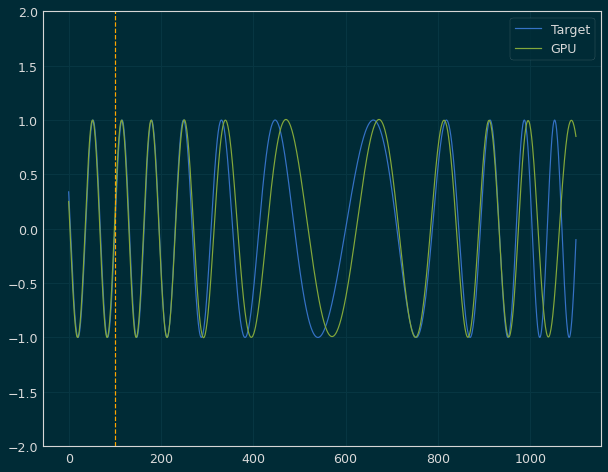

 Iter=64 a=0.201 sr=0.458 amp=1.569  ri=4.170 rr=3.826 loss=0.253849


Iter: 64 #### Diagnostic 0.254   Time 2.93  Best 0.254 NRMSE 0.254 CD 0.257
Iter: 65 #### Diagnostic 1000.000   Time 2.59  Best 0.254 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 0.427   Time 2.58  Best 0.254 NRMSE 0.427 CD 0.731
Iter: 67 #### Diagnostic 0.495   Time 2.58  Best 0.254 NRMSE 0.495 CD 0.981
Iter: 68 #### Diagnostic 0.390   Time 2.59  Best 0.254 NRMSE 0.390 CD 0.608
Iter: 69 #### Diagnostic 1000.000   Time 2.58  Best 0.254 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 0.324   Time 2.58  Best 0.254 NRMSE 0.324 CD 0.412
Iter: 71 #### Diagnostic 1000.000   Time 2.59  Best 0.254 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.59  Best 0.254 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.59  Best 0.254 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.59  Best 0.254 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.59  Best 0.254 NRMSE 1000.

Iter: 55 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 0.485   Time 2.59  Best 1000.000 NRMSE 0.485 CD 0.947
Iter: 58 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.570   Time 2.59  Best 1000.000 NRMSE 0.570 CD 1.299
Iter: 61 #### Diagnostic 0.513   Time 2.58  Best 1000.000 NRMSE 0.513 CD 1.047
Iter: 62 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Di

Iter: 53 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.481   Time 2.64  Best 1000.000 NRMSE 0.481 CD 0.930
Iter: 55 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.388   Time 2.59  Best 1000.000 NRMSE 0.388 CD 0.604
Iter: 62 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 ###

Iter: 50 #### Diagnostic 1000.000   Time 2.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.531   Time 2.59  Best 1000.000 NRMSE 0.531 CD 1.135
Iter: 55 #### Diagnostic 1000.000   Time 2.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62

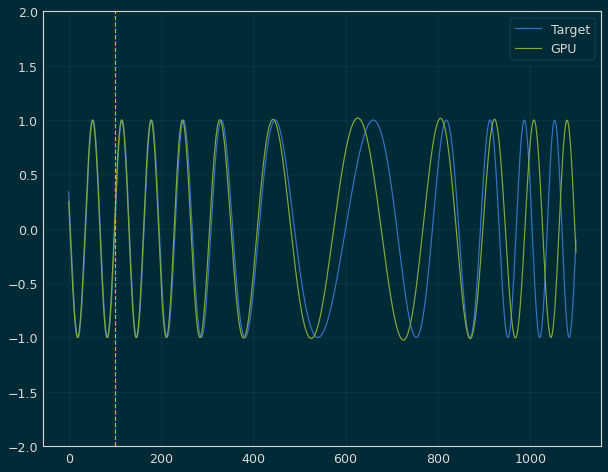

 Iter=64 a=0.261 sr=0.541 amp=1.612  ri=3.128 rr=3.353 loss=0.296775


Iter: 64 #### Diagnostic 0.297   Time 2.93  Best 0.297 NRMSE 0.297 CD 0.350
Iter: 65 #### Diagnostic 0.428   Time 2.61  Best 0.297 NRMSE 0.428 CD 0.730
Iter: 66 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 2.60  Best 0.297 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.464   Time 2.59  Best 0.297 NRMSE 0.464 CD 0.842
Iter: 69 #### Diagnostic 0.421   Time 2.59  Best 0.297 NRMSE 0.421 CD 0.707
Iter: 70 #### Diagnostic 1000.000   Time 2.59  Best 0.297 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.59  Best 0.297 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.59  Best 0.297 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.58  Best 0.297 NRMSE 1

Iter: 62 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 0.431   Time 2.59  Best 1000.000 NRMSE 0.431 CD 0.745
Iter: 67 #### Diagnostic 0.520   Time 2.58  Best 1000.000 NRMSE 0.520 CD 0.961
Iter: 68 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 0.497   Time 2.58  Best 1000.000 NRMSE 0.497 CD 1.001
Iter: 73 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Di

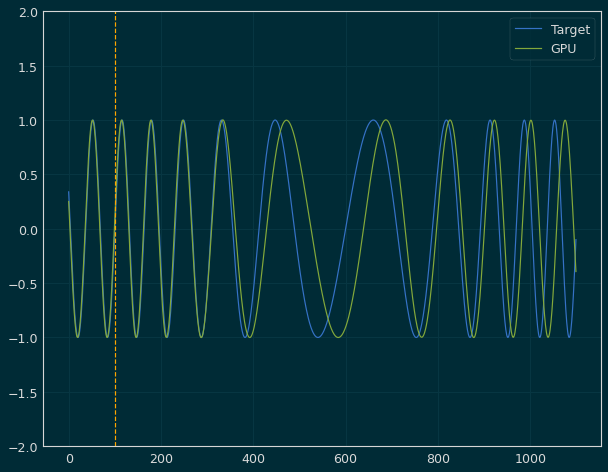

 Iter=54 a=0.260 sr=0.532 amp=1.254  ri=2.619 rr=0.028 loss=0.290829


Iter: 54 #### Diagnostic 0.291   Time 2.95  Best 0.291 NRMSE 0.291 CD 0.339
Iter: 55 #### Diagnostic 1000.000   Time 2.58  Best 0.291 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.59  Best 0.291 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.58  Best 0.291 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.58  Best 0.291 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.57  Best 0.291 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.58  Best 0.291 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.336   Time 2.59  Best 0.291 NRMSE 0.336 CD 0.454
Iter: 62 #### Diagnostic 1000.000   Time 2.58  Best 0.291 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 0.507   Time 2.57  Best 0.291 NRMSE 0.507 CD 1.031
Iter: 64 #### Diagnostic 1000.000   Time 2.57  Best 0.291 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.58  Best 0.291 NRM

Iter: 45 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.460   Time 2.44  Best 1000.000 NRMSE 0.460 CD 0.846
Iter: 48 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 0.368   Time 2.45  Best 1000.000 NRMSE 0.368 CD 0.549
Iter: 51 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 ###

Iter: 43 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.468   Time 2.44  Best 1000.000 NRMSE 0.468 CD 0.875
Iter: 55

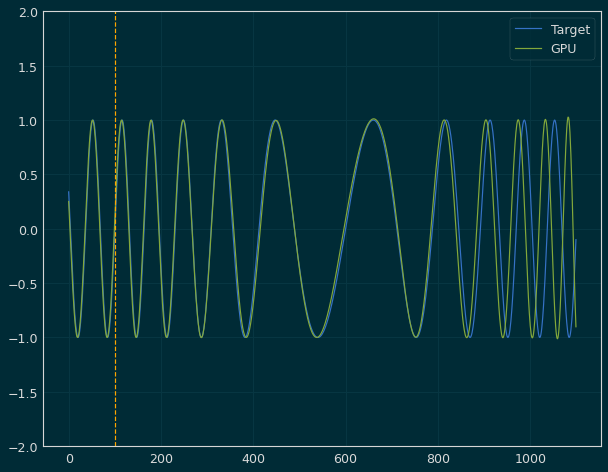

 Iter=36 a=0.244 sr=0.521 amp=1.751  ri=3.601 rr=2.051 loss=0.231600


Iter: 36 #### Diagnostic 0.232   Time 2.77  Best 0.232 NRMSE 0.232 CD 0.214
Iter: 37 #### Diagnostic 1000.000   Time 2.46  Best 0.232 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.45  Best 0.232 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.47  Best 0.232 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.45  Best 0.232 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.46  Best 0.232 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 0.303   Time 2.45  Best 0.232 NRMSE 0.303 CD 0.367
Iter: 43 #### Diagnostic 1000.000   Time 2.46  Best 0.232 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.47  Best 0.232 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.46  Best 0.232 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.46  Best 0.232 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.46  Best 0.232

Iter: 35 #### Diagnostic 1000.000   Time 2.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 32 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 0.418   Time 2.46  Best 1000.000 NRMSE 0.418 CD 0.694
Iter: 38 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44

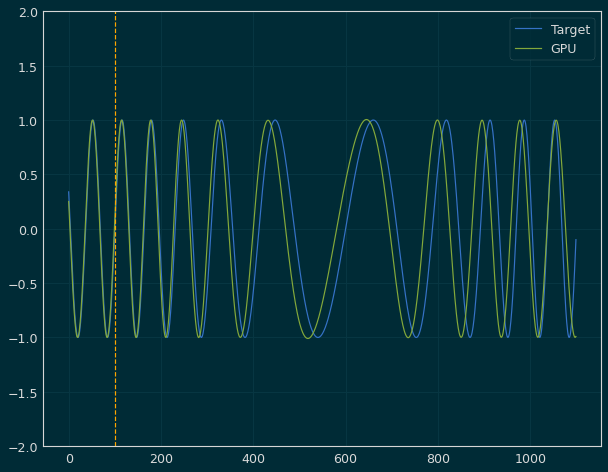

 Iter=54 a=0.260 sr=0.532 amp=1.254  ri=2.619 rr=0.028 loss=0.240374


Iter: 54 #### Diagnostic 0.240   Time 2.78  Best 0.240 NRMSE 0.240 CD 0.231
Iter: 55 #### Diagnostic 1000.000   Time 2.45  Best 0.240 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.45  Best 0.240 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.45  Best 0.240 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.45  Best 0.240 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 0.504   Time 2.44  Best 0.240 NRMSE 0.504 CD 1.012
Iter: 60 #### Diagnostic 1000.000   Time 2.44  Best 0.240 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.282   Time 2.45  Best 0.240 NRMSE 0.282 CD 0.315
Iter: 62 #### Diagnostic 0.465   Time 2.45  Best 0.240 NRMSE 0.465 CD 0.933
Iter: 63 #### Diagnostic 1000.000   Time 2.45  Best 0.240 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.45  Best 0.240 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.44  Best 0.240 NRMSE 1

Iter: 46 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.493   Time 2.45  Best 1000.000 NRMSE 0.493 CD 0.947
Iter: 55 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.342   Time 2.45  Best 1000.000 NRMSE 0.342 CD 0.469
Iter: 57 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 ###

Iter: 43 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.382   Time 2.45  Best 1000.000 NRMSE 0.382 CD 0.583
Iter: 55

Iter: 41 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 0.418   Time 2.42  Best 1000.000 NRMSE 0.418 CD 0.701
Iter: 51 #### Diagnostic 0.502   Time 2.43  Best 1000.000 NRMSE 0.502 CD 1.007
Iter: 52 #### Diagnostic 1000.000   Time 2.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 ###

Iter: 38 #### Diagnostic 1000.000   Time 2.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 3.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 36 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 0.409   Time 2.45  Best 1000.000 NRMSE 0.409 CD 0.667
Iter: 38 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48

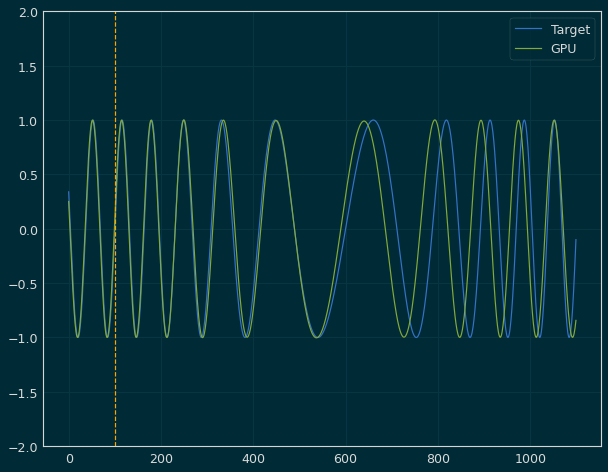

 Iter=23 a=0.230 sr=0.489 amp=1.450  ri=2.296 rr=3.231 loss=0.251339


Iter: 23 #### Diagnostic 0.251   Time 2.78  Best 0.251 NRMSE 0.251 CD 0.252
Iter: 24 #### Diagnostic 1000.000   Time 2.44  Best 0.251 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 2.44  Best 0.251 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.460   Time 2.44  Best 0.251 NRMSE 0.460 CD 0.852
Iter: 27 #### Diagnostic 1000.000   Time 2.44  Best 0.251 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.44  Best 0.251 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.44  Best 0.251 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.45  Best 0.251 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.346   Time 2.45  Best 0.251 NRMSE 0.346 CD 0.481
Iter: 32 #### Diagnostic 0.496   Time 2.44  Best 0.251 NRMSE 0.496 CD 0.976
Iter: 33 #### Diagnostic 1000.000   Time 2.44  Best 0.251 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.45  Best 0.251 NRMSE 1

Iter: 23 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter

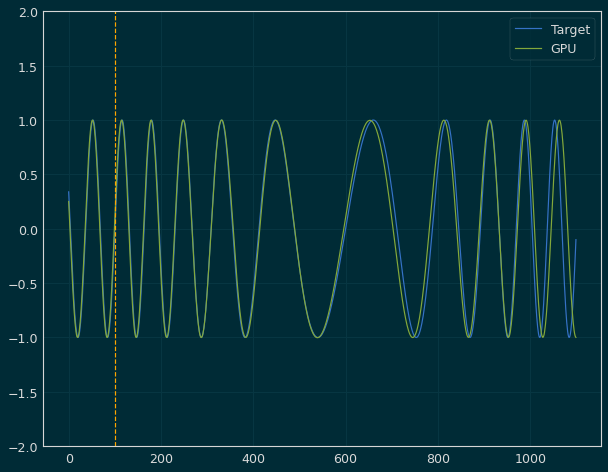

 Iter=55 a=0.245 sr=0.533 amp=1.609  ri=3.360 rr=0.397 loss=0.110009


Iter: 55 #### Diagnostic 0.110   Time 2.77  Best 0.110 NRMSE 0.110 CD 0.048
Iter: 56 #### Diagnostic 1000.000   Time 2.45  Best 0.110 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.44  Best 0.110 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.44  Best 0.110 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 0.441   Time 2.44  Best 0.110 NRMSE 0.441 CD 0.781
Iter: 60 #### Diagnostic 1000.000   Time 2.45  Best 0.110 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.406   Time 2.48  Best 0.110 NRMSE 0.406 CD 0.658
Iter: 62 #### Diagnostic 1000.000   Time 2.45  Best 0.110 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.44  Best 0.110 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.45  Best 0.110 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 0.520   Time 2.45  Best 0.110 NRMSE 0.520 CD 1.075
Iter: 66 #### Diagnostic 1000.000   Time 2.44  Best 0.110 NRMSE 1

Iter: 53 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.410   Time 2.44  Best 1000.000 NRMSE 0.410 CD 0.675
Iter: 61 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 0.488   Time 2.45  Best 1000.000 NRMSE 0.488 CD 0.957
Iter: 65 ###

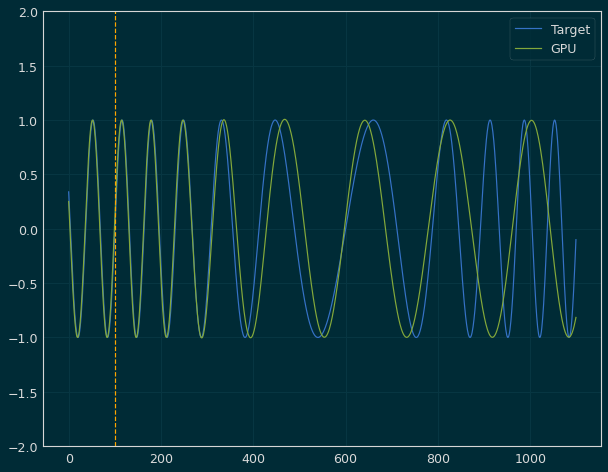

 Iter=75 a=0.243 sr=0.455 amp=1.384  ri=4.135 rr=2.218 loss=0.298606


Iter: 75 #### Diagnostic 0.299   Time 2.76  Best 0.299 NRMSE 0.299 CD 0.355
Iter: 76 #### Diagnostic 1000.000   Time 2.44  Best 0.299 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 2.45  Best 0.299 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.500   Time 2.45  Best 0.299 NRMSE 0.500 CD 0.996
Iter: 79 #### Diagnostic 1000.000   Time 2.44  Best 0.299 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.45  Best 0.299 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.457   Time 2.45  Best 0.299 NRMSE 0.457 CD 0.830
Iter: 82 #### Diagnostic 1000.000   Time 2.45  Best 0.299 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.44  Best 0.299 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.45  Best 0.299 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.44  Best 0.299 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.45  Best 0.299 NRM

Iter: 73 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.477   Time 2.45  Best 1000.000 NRMSE 0.477 CD 0.915
Iter: 76 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 894145176738585600.000 CD 1.000
Iter: 77 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 0.414   Time 2.46  Best 1000.000 NRMSE 0.414 CD 0.686
Iter: 80 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.484   Time 2.44  Best 1000.000 NRMSE 0.484 CD 0.946
Iter: 82 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 0.431   Time 2.46  Best 1000.000 NRMSE 0.431 CD 0.738
Iter

Iter: 71 #### Diagnostic 1000.000   Time 2.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 0.502   Time 2.44  Best 1000.000 NRMSE 0.502 CD 1.009
Iter: 77 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.469   Time 2.43  Best 1000.000 NRMSE 0.469 CD 0.880
Iter: 79 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan


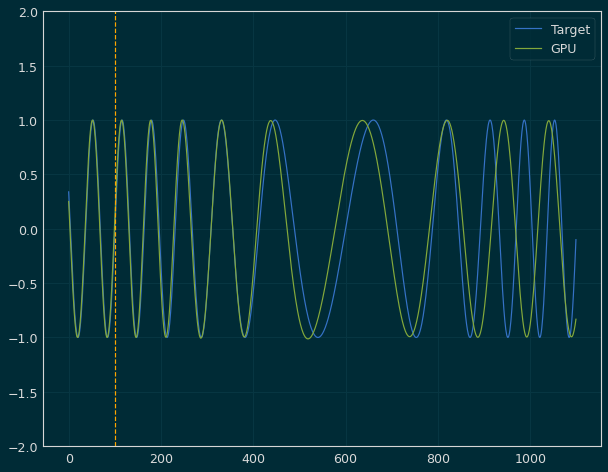

 Iter=82 a=0.245 sr=0.471 amp=1.426  ri=1.685 rr=2.903 loss=0.280431


Iter: 82 #### Diagnostic 0.280   Time 2.76  Best 0.280 NRMSE 0.280 CD 0.314
Iter: 83 #### Diagnostic 1000.000   Time 2.44  Best 0.280 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.44  Best 0.280 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.44  Best 0.280 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.44  Best 0.280 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 0.467   Time 2.44  Best 0.280 NRMSE 0.467 CD 0.878
Iter: 88 #### Diagnostic 1000.000   Time 2.44  Best 0.280 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.46  Best 0.280 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.45  Best 0.280 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.44  Best 0.280 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 2.45  Best 0.280 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.44  Best 0.280

Iter: 72 #### Diagnostic 0.520   Time 2.44  Best 1000.000 NRMSE 0.520 CD 1.090
Iter: 73 #### Diagnostic 0.493   Time 2.46  Best 1000.000 NRMSE 0.493 CD 0.968
Iter: 74 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.420   Time 2.45  Best 1000.000 NRMSE 0.420 CD 0.840
Iter: 78 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Di

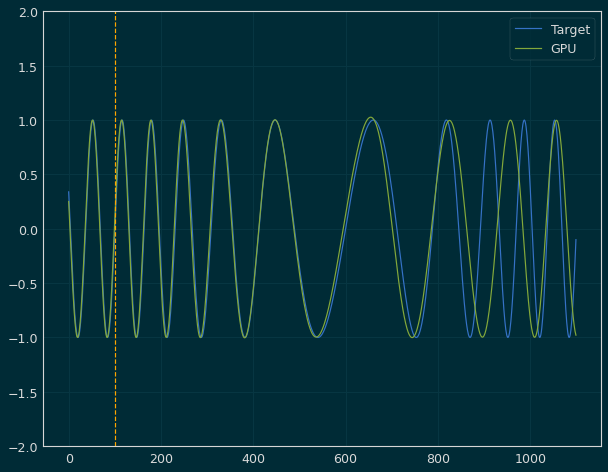

 Iter=89 a=0.241 sr=0.478 amp=1.736  ri=4.197 rr=4.396 loss=0.249440


Iter: 89 #### Diagnostic 0.249   Time 2.79  Best 0.249 NRMSE 0.249 CD 0.249
Iter: 90 #### Diagnostic 1000.000   Time 2.45  Best 0.249 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.45  Best 0.249 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 2.45  Best 0.249 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.46  Best 0.249 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 0.446   Time 2.45  Best 0.249 NRMSE 0.446 CD 0.995
Iter: 95 #### Diagnostic 1000.000   Time 2.44  Best 0.249 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 0.430   Time 2.44  Best 0.249 NRMSE 0.430 CD 0.740
Iter: 97 #### Diagnostic 1000.000   Time 2.45  Best 0.249 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 2.49  Best 0.249 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 2.53  Best 0.249 NRMSE 1000.000 CD nan

Best result = 0.24943973838270794
a = 0.24124407137691883
sr

Iter: 86 #### Diagnostic 0.495   Time 2.44  Best 1000.000 NRMSE 0.495 CD 0.977
Iter: 87 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.415   Time 2.45  Best 1000.000 NRMSE 0.415 CD 0.685
Iter: 92 #### Diagnostic 1000.000   Time 2.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 ###

Iter: 84 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 0.443   Time 2.45  Best 1000.000 NRMSE 0.443 CD 0.783
Iter: 90 #### Diagnostic 1000.000   Time 2.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 0.469   Time 2.46  Best 1000.000 NRMSE 0.469 CD 0.879
Iter: 93 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 0.466   Time 2.46  Best 1000.000 NRMSE 0.466 CD 0.863
Iter: 96 #### Di

Iter: 82 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 0.447   Time 2.45  Best 1000.000 NRMSE 0.447 CD 0.801
Iter: 86 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.455   Time 2.44  Best 1000.000 NRMSE 0.455 CD 0.803
Iter: 92 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 ###

Iter: 80 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.468   Time 2.44  Best 1000.000 NRMSE 0.468 CD 0.876
Iter: 82 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92

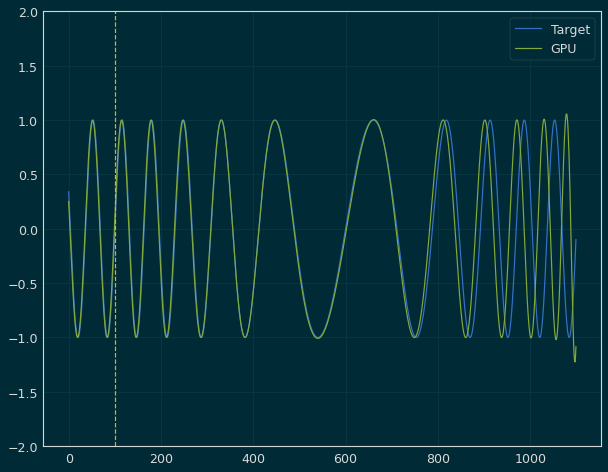

 Iter=9 a=0.292 sr=0.486 amp=1.781  ri=2.349 rr=4.118 loss=0.251907


Iter: 9 #### Diagnostic 0.252   Time 2.79  Best 0.252 NRMSE 0.252 CD 0.252
Iter: 10 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.422   Time 2.45  Best 0.252 NRMSE 0.422 CD 0.723
Iter: 12 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.46  Best 0.252 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.477   Time 2.46  Best 0.252 NRMSE 0.477 CD 0.787
Iter: 18 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 2.45  Best 0.252 NRMSE

Iter: 9 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.512   Time 2.45  Best 1000.000 NRMSE 0.512 CD 0.935
Iter: 13 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.425   Time 2.46  Best 1000.000 NRMSE 0.425 CD 0.722
Iter: 19 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 ####

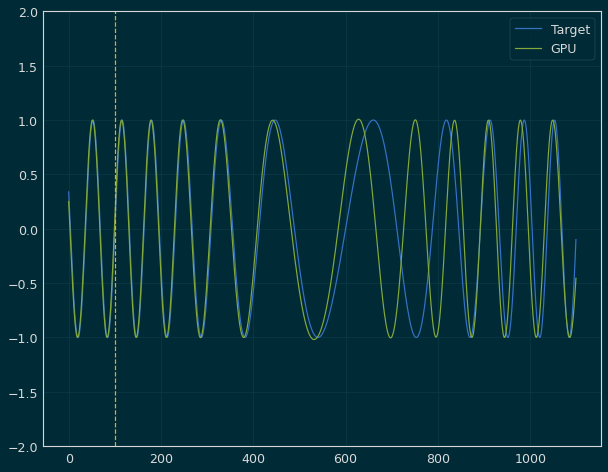

 Iter=26 a=0.207 sr=0.397 amp=1.585  ri=2.606 rr=4.051 loss=0.285295


Iter: 26 #### Diagnostic 0.285   Time 2.78  Best 0.285 NRMSE 0.285 CD 0.324
Iter: 27 #### Diagnostic 1000.000   Time 2.45  Best 0.285 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 0.506   Time 2.45  Best 0.285 NRMSE 0.506 CD 0.983
Iter: 29 #### Diagnostic 1000.000   Time 2.45  Best 0.285 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.547   Time 2.46  Best 0.285 NRMSE 0.547 CD 1.194
Iter: 31 #### Diagnostic 1000.000   Time 2.44  Best 0.285 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 2.45  Best 0.285 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.45  Best 0.285 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.46  Best 0.285 NRMSE 927321839108366180286464.000 CD 1.000
Iter: 35 #### Diagnostic 1000.000   Time 2.44  Best 0.285 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 2.45  Best 0.285 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Tim

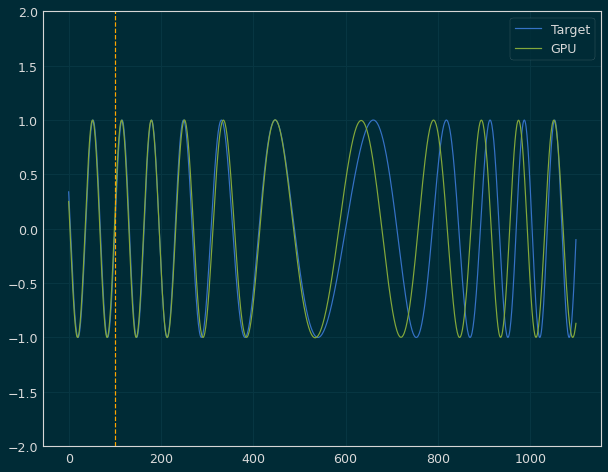

 Iter=53 a=0.215 sr=0.546 amp=1.295  ri=4.325 rr=0.340 loss=0.268702


Iter: 53 #### Diagnostic 0.269   Time 2.76  Best 0.269 NRMSE 0.269 CD 0.288
Iter: 54 #### Diagnostic 0.487   Time 2.45  Best 0.269 NRMSE 0.487 CD 0.955
Iter: 55 #### Diagnostic 0.501   Time 2.46  Best 0.269 NRMSE 0.501 CD 1.004
Iter: 56 #### Diagnostic 1000.000   Time 2.44  Best 0.269 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.45  Best 0.269 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.45  Best 0.269 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.45  Best 0.269 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.45  Best 0.269 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.449   Time 2.44  Best 0.269 NRMSE 0.449 CD 0.808
Iter: 62 #### Diagnostic 1000.000   Time 2.44  Best 0.269 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.45  Best 0.269 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.45  Best 0.269 NRMSE 1

Iter: 51 #### Diagnostic 0.415   Time 2.44  Best 1000.000 NRMSE 0.415 CD 0.687
Iter: 52 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.518   Time 2.45  Best 1000.000 NRMSE 0.518 CD 1.080
Iter: 61 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 ###

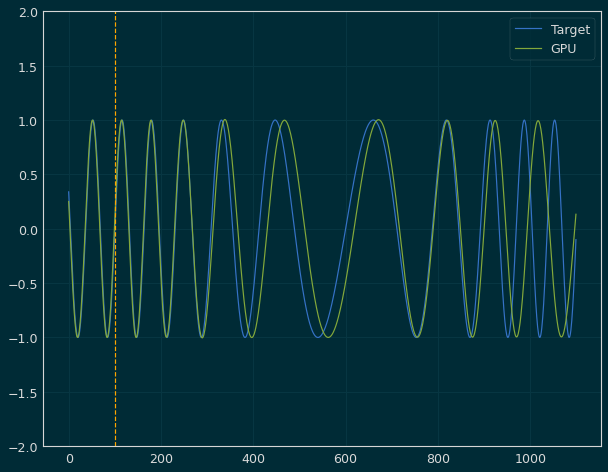

 Iter=23 a=0.257 sr=0.537 amp=1.509  ri=3.161 rr=3.777 loss=0.270092


Iter: 23 #### Diagnostic 0.270   Time 2.77  Best 0.270 NRMSE 0.270 CD 0.293
Iter: 24 #### Diagnostic 1000.000   Time 2.46  Best 0.270 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 2.45  Best 0.270 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 2.45  Best 0.270 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 2.45  Best 0.270 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.45  Best 0.270 NRMSE 733503229274788.125 CD 0.988
Iter: 29 #### Diagnostic 1000.000   Time 2.44  Best 0.270 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.45  Best 0.270 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.360   Time 2.44  Best 0.270 NRMSE 0.360 CD 0.519
Iter: 32 #### Diagnostic 1000.000   Time 2.44  Best 0.270 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.44  Best 0.270 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.4

Iter: 23 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.495   Time 2.45  Best 1000.000 NRMSE 0.495 CD 0.977
Iter: 27 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35

Iter: 13 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 0.439   Time 2.36  Best 1000.000 NRMSE 0.439 CD 0.767
Iter: 17 #### Diagnostic 0.508   Time 2.37  Best 1000.000 NRMSE 0.508 CD 0.939
Iter: 18 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 ###

Iter: 11 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.503   Time 2.36  Best 1000.000 NRMSE 0.503 CD 0.977
Iter: 13 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.429   Time 2.36  Best 1000.000 NRMSE 0.429 CD 0.740
Iter: 19 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 ###

Iter: 8 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.480   Time 2.36  Best 1000.000 NRMSE 0.480 CD 0.926
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.397   Time 2.37  Best 1000.000 NRMSE 0.397 CD 0.632
Iter: 16 #### Diagnostic 0.443   Time 2.36  Best 1000.000 NRMSE 0.443 CD 0.787
Iter: 17 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diag

Iter: 6 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.490   Time 2.36  Best 1000.000 NRMSE 0.490 CD 0.958
Iter: 9 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 ###

Iter: 3 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 0.418   Time 2.36  Best 1000.000 NRMSE 0.418 CD 0.697
Iter: 8 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.374   Time 2.36  Best 1000.000 NRMSE 0.374 CD 0.555
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagn

Iter: 0 #### Diagnostic 1000.000   Time 2.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### 


Best result = 0.3432696884490597
a = 0.22629371741053414
sr = 0.5111266636060456
amp = 0.24860122162038342
ri = 0.18089472089571515
rr = 3.8888540607493582

 ********** size100 ref1 run 1 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.465   Time 2.47  Best 1000.000 NRMSE 0.465 CD 0.865
Iter: 4 #### Diagnostic 1000.000   Time 2.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE

Iter: 97 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.33491544549082564
a = 0.25364847513416516
sr = 0.47277327734703944
amp = 1.4345921399120047
ri = 2.2028707801597367
rr = 2.559170197156733

 ********** size100 ref1 run 2 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.444   Time 2.36  Best 1000.000 NR

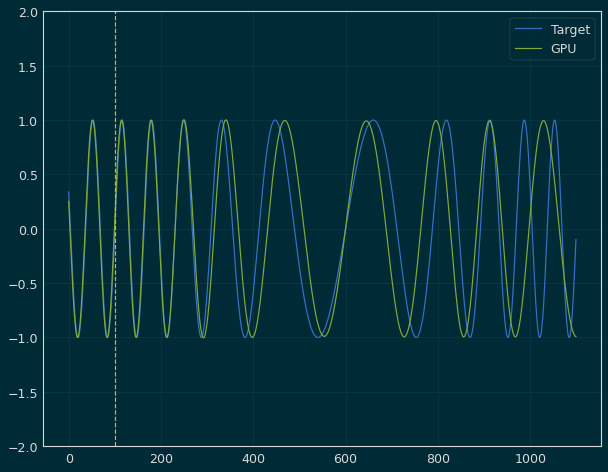

 Iter=71 a=0.205 sr=0.541 amp=1.451  ri=2.699 rr=4.989 loss=0.281769


Iter: 71 #### Diagnostic 0.282   Time 2.67  Best 0.282 NRMSE 0.282 CD 0.319
Iter: 72 #### Diagnostic 1000.000   Time 2.35  Best 0.282 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.36  Best 0.282 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.36  Best 0.282 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.449   Time 2.36  Best 0.282 NRMSE 0.449 CD 0.812
Iter: 76 #### Diagnostic 1000.000   Time 2.35  Best 0.282 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 2.36  Best 0.282 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 2.36  Best 0.282 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.35  Best 0.282 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.35  Best 0.282 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.507   Time 2.35  Best 0.282 NRMSE 0.507 CD 1.021
Iter: 82 #### Diagnostic 1000.000   Time 2.38  Best 0.282 NRM

Iter: 69 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 67 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 58 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter

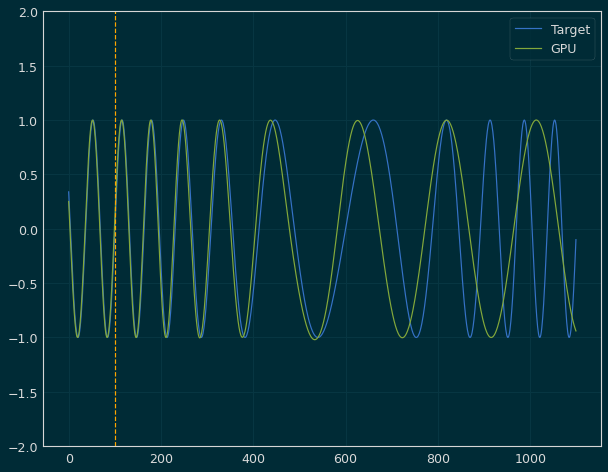

 Iter=3 a=0.241 sr=0.369 amp=1.656  ri=3.365 rr=4.132 loss=0.299872


Iter: 3 #### Diagnostic 0.300   Time 2.67  Best 0.300 NRMSE 0.300 CD 0.361
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 0.300 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.35  Best 0.300 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.466   Time 2.36  Best 0.300 NRMSE 0.466 CD 0.872
Iter: 7 #### Diagnostic 1000.000   Time 2.35  Best 0.300 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.36  Best 0.300 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.36  Best 0.300 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 0.300 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 0.300 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.511   Time 2.37  Best 0.300 NRMSE 0.511 CD 0.967
Iter: 13 #### Diagnostic 1000.000   Time 2.36  Best 0.300 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.36  Best 0.300 NRMSE 1000.

Iter: 3 #### Diagnostic 0.414   Time 2.38  Best 1000.000 NRMSE 0.414 CD 0.687
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.492   Time 2.36  Best 1000.000 NRMSE 0.492 CD 0.960
Iter: 6 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 2235975.343 CD 1.012
Iter: 7 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.466   Time 2.36  Best 1000.000 NRMSE 0.466 CD 0.876
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diag

Iter: 1 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 0.444   Time 2.37  Best 1000.000 NRMSE 0.444 CD 0.790
Iter: 3 #### Diagnostic 1000.000   Time 2.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.534   Time 2.36  Best 1000.000 NRMSE 0.534 CD 1.139
Iter: 11 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnos

Iter: 0 #### Diagnostic 0.460   Time 2.36  Best 1000.000 NRMSE 0.460 CD 0.849
Iter: 1 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 0.459   Time 2.37  Best 1000.000 NRMSE 0.459 CD 0.841
Iter: 8 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnost


Best result = 0.3522649746923241
a = 0.2607939000841302
sr = 0.4186556016588717
amp = 1.5209069296767173
ri = 1.7735376332410395
rr = 2.981821109934219

Best mn:0.241	 mn:0.241
New bounds mn--mx: 0.044--0.043

Best mn:0.369	 mn:0.369
New bounds mn--mx: 0.006--0.157

Best mn:1.656	 mn:1.656
New bounds mn--mx: 0.440--0.210

Best mn:3.365	 mn:3.365
New bounds mn--mx: 1.007--0.867

Best mn:4.132	 mn:4.132
New bounds mn--mx: 0.819--1.056
Refined search bounds:

Alpha (0.19660198551722602, 0.284101985517226)

Rho (0.36356858765834876, 0.5260685876583487)

Gamma (1.2157943689893804, 1.8657943689893803)

r-in (2.357292971142484, 4.232167971142484)

r-res (3.3135168874540026, 5.188391887454003)

End Refinement Run 2 Time 1193.515

 ********** size100 ref3 run 0 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 

Iter: 91 #### Diagnostic 0.520   Time 2.37  Best 1000.000 NRMSE 0.520 CD 1.066
Iter: 92 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 0.532   Time 2.37  Best 1000.000 NRMSE 0.532 CD 1.138
Iter: 98 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.37470216538302714
a = 0.287321699450299
sr = 0.508829163929776
amp = 1.2364350236957642
ri = 2.445661311083389
rr = 1.2461339084267777

 ********** size100 ref3 run 1 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE

Iter: 89 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 0.436   Time 2.35  Best 1000.000 NRMSE 0.436 CD 0.760
Iter: 91 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.3308092202994297
a = 0.28258226404909187
sr = 0.5248118867049221
amp = 1.4

Iter: 86 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 0.436   Time 2.36  Best 1000.000 NRMSE 0.436 CD 0.765
Iter: 89 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98

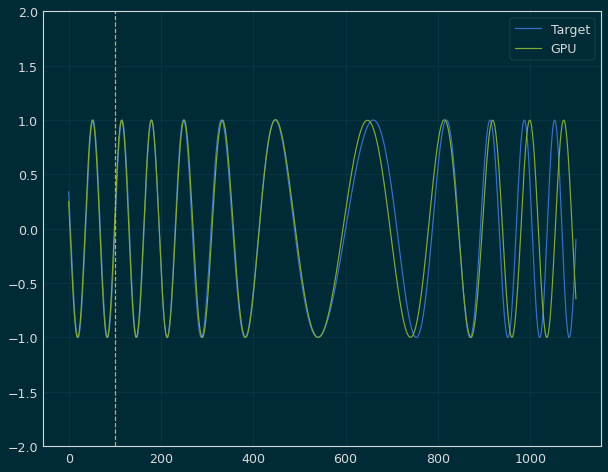

 Iter=83 a=0.272 sr=0.412 amp=1.671  ri=2.612 rr=2.387 loss=0.192193


Iter: 83 #### Diagnostic 0.192   Time 2.70  Best 0.192 NRMSE 0.192 CD 0.148
Iter: 84 #### Diagnostic 0.480   Time 2.37  Best 0.192 NRMSE 0.480 CD 0.925
Iter: 85 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 0.442   Time 2.39  Best 0.192 NRMSE 0.442 CD 0.778
Iter: 89 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.412   Time 2.37  Best 0.192 NRMSE 0.412 CD 0.755
Iter: 92 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.37  Best 0.192 NRMSE 1

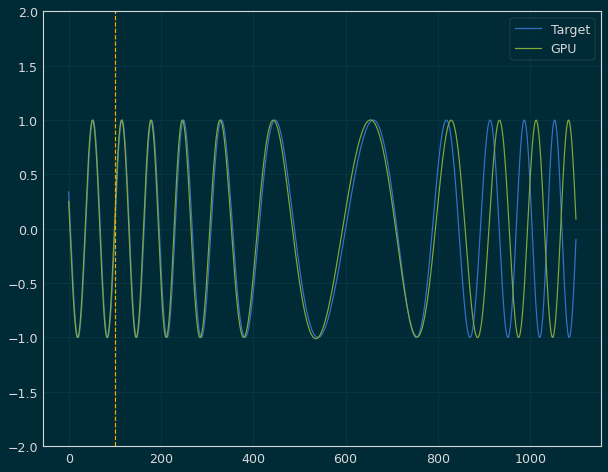

 Iter=9 a=0.234 sr=0.543 amp=1.660  ri=2.507 rr=4.853 loss=0.295412


Iter: 9 #### Diagnostic 0.295   Time 2.86  Best 0.295 NRMSE 0.295 CD 0.349
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 0.295 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 0.295 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.36  Best 0.295 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.35  Best 0.295 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 2.35  Best 0.295 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.472   Time 2.36  Best 0.295 NRMSE 0.472 CD 0.892
Iter: 16 #### Diagnostic 1000.000   Time 2.35  Best 0.295 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 2.36  Best 0.295 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 2.36  Best 0.295 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 2.36  Best 0.295 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 2.36  Best 0.295 N

Iter: 2 #### Diagnostic 0.556   Time 2.37  Best 1000.000 NRMSE 0.556 CD 1.228
Iter: 3 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.512   Time 2.37  Best 1000.000 NRMSE 0.512 CD 1.055
Iter: 6 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 0.387   Time 2.37  Best 1000.000 NRMSE 0.387 CD 0.601
Iter: 8 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic

Iter: 0 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 133232.527 CD 0.989
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #


Best result = 0.35536077628550944
a = 0.29688873321645803
sr = 0.38840813164396387
amp = 1.2665042632140895
ri = 4.010269487291791
rr = 2.1633940606245394

 ********** size100 ref4 run 2 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 2.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NR

Iter: 98 #### Diagnostic 0.436   Time 2.36  Best 1000.000 NRMSE 0.436 CD 0.759
Iter: 99 #### Diagnostic 0.536   Time 2.36  Best 1000.000 NRMSE 0.536 CD 1.161

Best result = 0.3349541476496056
a = 0.28632516098180105
sr = 0.46849479254070675
amp = 1.6353017751435766
ri = 2.742091737837047
rr = 4.211363862376754

 ********** size100 ref4 run 3 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.475   Time 2.37  Best 1000.000 NRMSE 0.475 CD 0.904
Iter: 6 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000

Iter: 96 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.34345218403729233
a = 0.2715832152013813
sr = 0.41187792366468096
amp = 1.6714173720770014
ri = 2.611988236590646
rr = 2.3867299452660253

 ********** size100 ref4 run 4 ***********
Iter: 0 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.457   Time 2.35  Best 1000.000 NRMSE 0.457 CD 0.837
Iter: 5 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRM

Iter: 94 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 0.518   Time 2.37  Best 1000.000 NRMSE 0.518 CD 0.985
Iter: 96 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.385896177771335
a = 0.2929146965158018
sr = 0.4055347752275229
amp = 1.3240565918521443
ri = 3.0747637873220715
rr = 0.5867271775367786
Refined search bounds:

Alpha (0.10752806772245861, 0.41676390053895546)

Rho (0.19386162783075744, 0.8018578192747413)

Gamma (0.7188336562292315, 2.652908805799786)

r-in (1.2160923529294025, 5.133117155799848)

r-res (1.425061708180007, 7.530681947652504)

End Refinement Run 4 Time 1192.778

 ********** size50 ref0 run 0 ***********
Iter: 0 #### Di

Iter: 88 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 0.489   Time 2.36  Best 1000.000 NRMSE 0.489 CD 0.930
Iter: 95 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 0.387   Time 2.49  Best 1000.000 NRMSE 0.387 CD 0.600
Iter: 97 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 0.388   Time 2.37  Best 1000.000 NRMSE 0.388 CD 0.601
Iter: 99 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0

Iter: 86 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 83 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 0.370   Time 2.35  Best 1000.000 NRMSE 0.370 CD 0.545
Iter: 90 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.464   Time 2.35  Best 1000.000 NRMSE 0.464 CD 0.869
Iter: 92 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 ###

Iter: 80 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 0.514   Time 2.46  Best 1000.000 NRMSE 0.514 CD 1.064
Iter: 89 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.527   Time 2.46  Best 1000.000 NRMSE 0.527 CD 0.943
Iter: 92 ###

Iter: 77 #### Diagnostic 1000.000   Time 3.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 3.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 3.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000   Time 3.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 3.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 0.419   Time 3.38  Best 1000.000 NRMSE 0.419 CD 0.702
Iter: 89

Iter: 72 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.348   Time 2.46  Best 1000.000 NRMSE 0.348 CD 0.708
Iter: 78 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 0.490   Time 2.46  Best 1000.000 NRMSE 0.490 CD 0.961
Iter: 83 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 ###

Iter: 70 #### Diagnostic 1000.000   Time 2.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 0.464   Time 2.39  Best 1000.000 NRMSE 0.464 CD 0.851
Iter: 75 #### Diagnostic 0.441   Time 2.36  Best 1000.000 NRMSE 0.441 CD 0.773
Iter: 76 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 2.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 2.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 ###

Iter: 68 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 0.366   Time 2.36  Best 1000.000 NRMSE 0.366 CD 0.536
Iter: 75 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.437   Time 2.35  Best 1000.000 NRMSE 0.437 CD 0.765
Iter: 78 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 ###

Iter: 65 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 0.428   Time 2.45  Best 1000.000 NRMSE 0.428 CD 0.881
Iter: 68 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 0.434   Time 2.45  Best 1000.000 NRMSE 0.434 CD 0.776
Iter: 71 #### Diagnostic 0.532   Time 2.45  Best 1000.000 NRMSE 0.532 CD 1.140
Iter: 72 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 0.428   Time 2.46  Best 1000.000 NRMSE 0.428 CD 0.742
Iter: 75 #### Diagnostic 0.397   Time 2.46  Best 1000.000 NRMSE 0.397 CD 0.632
Iter: 76 #### Diagnostic 1000.000   Time 2.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic

Iter: 63 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 58 #### Diagnostic 0.516   Time 2.35  Best 1000.000 NRMSE 0.516 CD 1.068
Iter: 59 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 2.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70

Iter: 56 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 53 #### Diagnostic 0.349   Time 2.34  Best 1000.000 NRMSE 0.349 CD 0.723
Iter: 54 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 2.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.435   Time 2.36  Best 1000.000 NRMSE 0.435 CD 0.758
Iter: 61 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 ###

Iter: 50 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.431   Time 2.34  Best 1000.000 NRMSE 0.431 CD 0.747
Iter: 55 #### Diagnostic 0.438   Time 2.35  Best 1000.000 NRMSE 0.438 CD 0.766
Iter: 56 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 ###

Iter: 48 #### Diagnostic 0.423   Time 2.33  Best 1000.000 NRMSE 0.423 CD 0.724
Iter: 49 #### Diagnostic 0.482   Time 2.34  Best 1000.000 NRMSE 0.482 CD 0.729
Iter: 50 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 ###

Iter: 43 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.463   Time 2.33  Best 1000.000 NRMSE 0.463 CD 0.863
Iter: 48 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 0.472   Time 2.35  Best 1000.000 NRMSE 0.472 CD 0.885
Iter: 52 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.497   Time 2.34  Best 1000.000 NRMSE 0.497 CD 0.726
Iter: 55 #### Di

Iter: 41 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 38 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 35 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 33 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.429   Time 2.34  Best 1000.000 NRMSE 0.429 CD 0.735
Iter: 36 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 0.469   Time 2.35  Best 1000.000 NRMSE 0.469 CD 0.877
Iter: 44 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 ###

Iter: 28 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.537   Time 2.35  Best 1000.000 NRMSE 0.537 CD 0.981
Iter: 33 #### Diagnostic 0.500   Time 2.35  Best 1000.000 NRMSE 0.500 CD 0.998
Iter: 34 #### Diagnostic 0.388   Time 2.34  Best 1000.000 NRMSE 0.388 CD 0.601
Iter: 35 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Di

Iter: 25 #### Diagnostic 0.341   Time 3.41  Best 1000.000 NRMSE 0.341 CD 0.473
Iter: 26 #### Diagnostic 1000.000   Time 3.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 3.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 3.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 3.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.451   Time 3.40  Best 1000.000 NRMSE 0.451 CD 0.820
Iter: 31 #### Diagnostic 1000.000   Time 3.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 2.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000   Time 2.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 0.456   Time 2.45  Best 1000.000 NRMSE 0.456 CD 0.821
Iter: 37 #### Di

Iter: 23 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.457   Time 2.34  Best 1000.000 NRMSE 0.457 CD 0.841
Iter: 25 #### Diagnostic 0.442   Time 2.34  Best 1000.000 NRMSE 0.442 CD 0.779
Iter: 26 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 ###

Iter: 20 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 0.393   Time 2.34  Best 1000.000 NRMSE 0.393 CD 0.615
Iter: 32

Iter: 17 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 2.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 2.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 2.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 2.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter

In [4]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)

size = [300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .2, .3
    min_sr, max_sr = .35, .55
    min_g, max_g = .2, 1.8
    min_ri, max_ri = .001, 5.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** size{N} ref{ref} run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')